In [29]:
import pandas as pd

df_expenses = pd.read_csv('expenses.csv')
df_expenses.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Axes: >

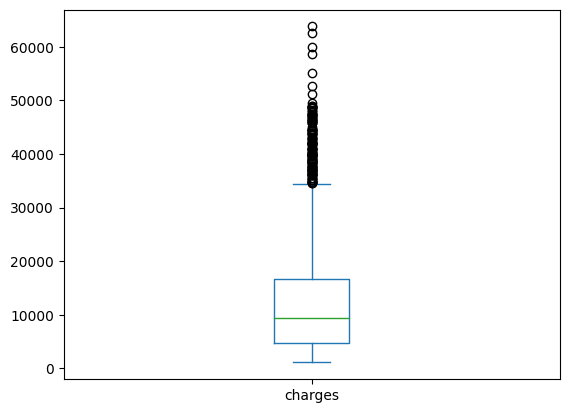

In [30]:
df_expenses.charges.plot(kind='box')

In [31]:
# outlier removal

from pandas.api.types import is_numeric_dtype 

def remove_outlier(df_ex):
  for col_name in list(df_ex.columns):
    if is_numeric_dtype(df_ex[col_name]):
      q1 = df_ex[col_name].quantile(0.25)
      q3 = df_ex[col_name].quantile(0.75)

      iqr = q3-q1
      batas_atas = q3+(iqr*1.5)
      batas_bawah = q1-(iqr*1.5)

      df_out = df_ex.loc[(df_ex[col_name]>=batas_bawah) & (df_ex[col_name]<=batas_atas)]
  return df_out 

df_expenses_clean = remove_outlier(df_expenses)
print("Jumlah baris DataFrame sebelum remove outlier", df_expenses.shape[0])
print("Jumlah baris DataFrame setelah remove outlier", df_expenses_clean.shape[0])

Jumlah baris DataFrame sebelum remove outlier 1338
Jumlah baris DataFrame setelah remove outlier 1199


<Axes: >

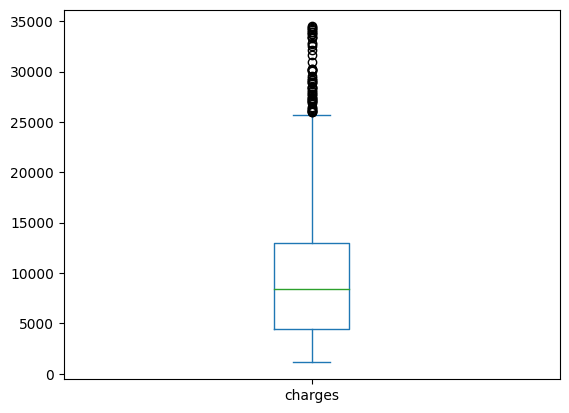

In [32]:
df_expenses_clean.charges.plot(kind='box')

In [33]:
# train test split

from sklearn.model_selection import train_test_split

X = df_expenses_clean.drop(columns='charges', axis=1)
y = df_expenses_clean.charges

X_train_ins, X_test_ins, y_train_ins, y_test_ins = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

cat_cols = ['sex', 'smoker', 'region']

preprocessor = make_column_transformer(
    (OneHotEncoder(), cat_cols),
    remainder='passthrough'
)

X_train_enc = preprocessor.fit_transform(X_train_ins)
X_test_enc = preprocessor.transform(X_test_ins)

df_train_enc = pd.DataFrame(X_train_enc, columns=preprocessor.get_feature_names_out())
df_test_enc = pd.DataFrame(X_test_enc, columns=preprocessor.get_feature_names_out())

df_train_enc.head(10)
df_test_enc.head(10)

,onehotencoder__sex_female,onehotencoder__sex_male,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,remainder__age,remainder__bmi,remainder__children
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,18.0,28.310,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,35.0,27.100,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,27.940,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,18.0,25.080,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,28.0,23.980,3.0
5,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,36.0,30.875,1.0
6,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,42.0,24.985,2.0
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,39.0,18.300,5.0
8,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,62.0,38.095,2.0
9,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,50.0,30.970,3.0


In [35]:
# MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

mm_scaler.fit(X_train_enc)
X_train_mmscaled = mm_scaler.transform(X_train_enc)
X_test_mmscaled = mm_scaler.transform(X_test_enc)

print("Minimum before scaling:\n", X_train_enc.min(axis=0))
print("Maximum before scaling:\n", X_train_enc.max(axis=0))
print("Minimum after scaling:\n", X_train_mmscaled.min(axis=0))
print("Maximum after scaling:\n", X_train_mmscaled.max(axis=0))

Minimum before scaling:
 [ 0.    0.    0.    0.    0.    0.    0.    0.   18.   15.96  0.  ]
Maximum before scaling:
 [ 1.    1.    1.    1.    1.    1.    1.    1.   64.   53.13  5.  ]
Minimum after scaling:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Maximum after scaling:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [36]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

RFR = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=7).fit(X_train_enc, y_train_ins)
RFR_mmscaled = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=7).fit(X_train_mmscaled, y_train_ins)

df_result = pd.DataFrame(y_test_ins)

df_result['RFR prediction'] = RFR.predict(X_test_enc)
df_result['RFR prediction mmscaled'] = RFR_mmscaled.predict(X_test_mmscaled)

# RMSE
print("RMSE RFR before scaling:", format(mean_squared_error(y_test_ins, df_result['RFR prediction'], squared=False)))
print("RMSE RFR after scaling:", format(mean_squared_error(y_test_ins, df_result['RFR prediction mmscaled'], squared=False)))

df_result.head(10)

RMSE RFR before scaling: 4872.350517723474
RMSE RFR after scaling: 4872.191054537495


,charges,RFR prediction,RFR prediction mmscaled
1315,11272.33139,3031.478963,3031.478963
965,4746.34400,6081.295336,6081.295336
117,19107.77960,18787.894600,18787.894600
492,2196.47320,2973.515178,2973.515178
69,17663.14420,18310.058165,18310.058165
1210,5373.36425,6171.189552,6171.189552
367,8017.06115,6984.495711,6984.495711
1085,19023.26000,23711.765326,23711.765326
462,15230.32405,15070.304300,15070.304300
1333,10600.54830,11611.273771,11611.273771


In [37]:
# Ridge Regression

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5).fit(X_train_mmscaled, y_train_ins)
RD_pred = ridge.predict(X_test_mmscaled)

df_result['Ridge prediction'] = RD_pred
df_result.head(10)

,charges,RFR prediction,RFR prediction mmscaled,Ridge prediction
1315,11272.33139,3031.478963,3031.478963,3129.332471
965,4746.34400,6081.295336,6081.295336,5883.620017
117,19107.77960,18787.894600,18787.894600,20436.825666
492,2196.47320,2973.515178,2973.515178,3067.257742
69,17663.14420,18310.058165,18310.058165,20122.869842
1210,5373.36425,6171.189552,6171.189552,7526.921016
367,8017.06115,6984.495711,6984.495711,9490.072632
1085,19023.26000,23711.765326,23711.765326,23210.297256
462,15230.32405,15070.304300,15070.304300,15475.003883
1333,10600.54830,11611.273771,11611.273771,11699.655476


In [38]:
# Ridge Performance Evaluation

from sklearn import metrics
import numpy as np

print("Mean Absolute Error", metrics.mean_absolute_error(y_test_ins, RD_pred))
print("Mean Squared Error", metrics.mean_squared_error(y_test_ins, RD_pred))
print("Root Mean Squared Error", np.sqrt(metrics.mean_squared_error(y_test_ins, RD_pred)))

Mean Absolute Error 2706.8833567367096
Mean Squared Error 26026496.197772022
Root Mean Squared Error 5101.617017943627


In [39]:
# Lasso Regression

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.5).fit(X_train_mmscaled, y_train_ins)
LS_pred = lasso.predict(X_test_mmscaled)

df_result['Lasso prediction'] = LS_pred
df_result.head(10)

,charges,RFR prediction,RFR prediction mmscaled,Ridge prediction,Lasso prediction
1315,11272.33139,3031.478963,3031.478963,3129.332471,3093.875021
965,4746.34400,6081.295336,6081.295336,5883.620017,5869.142038
117,19107.77960,18787.894600,18787.894600,20436.825666,20464.130421
492,2196.47320,2973.515178,2973.515178,3067.257742,3025.946830
69,17663.14420,18310.058165,18310.058165,20122.869842,20147.177833
1210,5373.36425,6171.189552,6171.189552,7526.921016,7516.858605
367,8017.06115,6984.495711,6984.495711,9490.072632,9482.465757
1085,19023.26000,23711.765326,23711.765326,23210.297256,23247.095902
462,15230.32405,15070.304300,15070.304300,15475.003883,15515.406490
1333,10600.54830,11611.273771,11611.273771,11699.655476,11712.672400


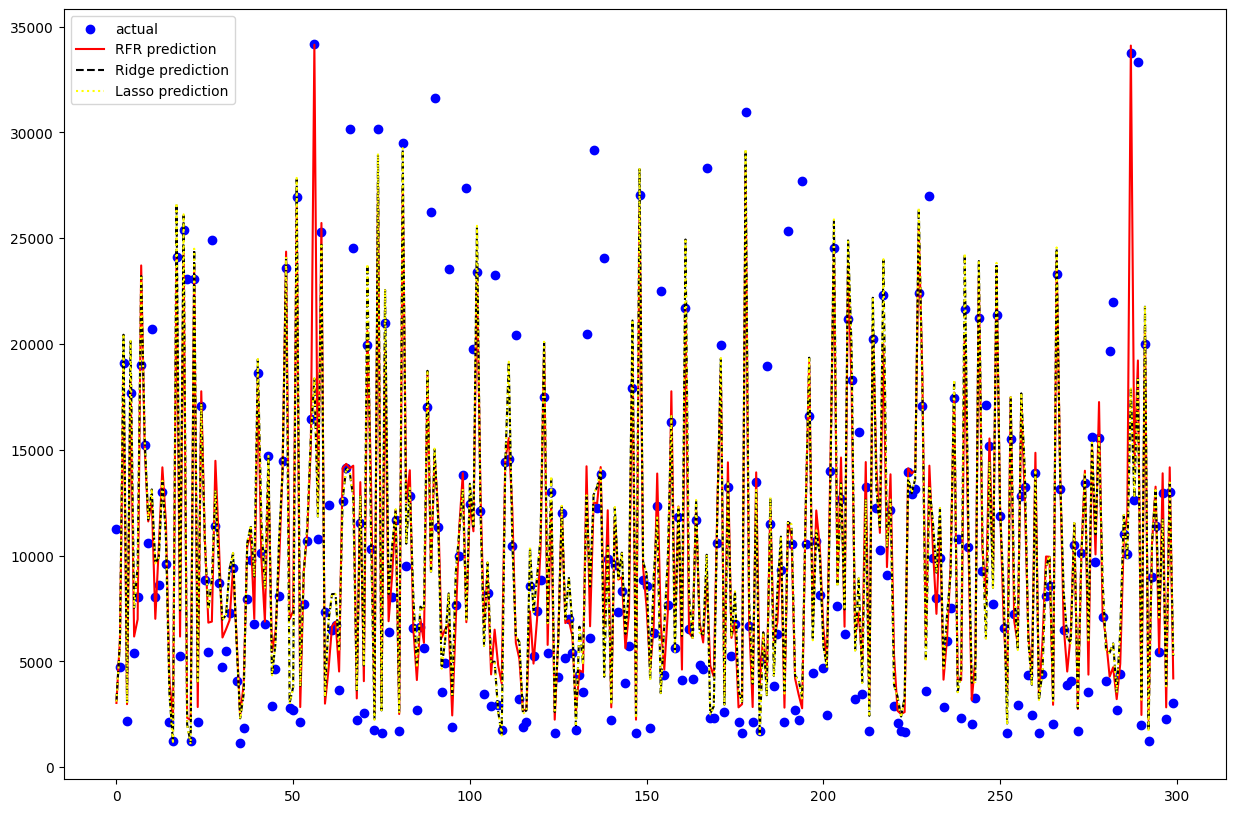

In [40]:
# Lasso Performance Evaluation

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
data_length = range(len(y_test_ins))
plt.scatter(data_length, df_result.charges, color='blue', label='actual')
plt.plot(data_length, df_result['RFR prediction'], color='red', label='RFR prediction')
plt.plot(data_length, df_result['Ridge prediction'], color='black', linestyle='--', label='Ridge prediction')
plt.plot(data_length, df_result['Lasso prediction'], color='yellow', linestyle=':', label='Lasso prediction')

plt.legend()
plt.show()

1. Apakah ada pengaruh penskalaan data pada dataset terhadap performa model
machine learning untuk regresi?

Jawab : Penskalaan data memberikan pengaruh pada hasil RMSE. Dimana data yang diskalakan memiliki nilai yang lebih kecil.

2. Model apa yang paling cocok digunakan untuk kasus tersebut?

Jawab : Model RandomForestRegression